# Design Project 1: Code for Single-Gimbal Control Moment Gyroscope (CMG) 

### Ishaan Kandamuri

In [1]:
import condynsate # this should run without any errors

pybullet build time: Oct 14 2023 16:00:11


In [2]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N, lambdify
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read
from scipy import signal

# Equations of Motion

The below section is copied from the ae353_cmg-EOM.ipynb file.

### Constants

In [3]:
# Constants of the system
mp = 0.5      # Mass of the sphere on the top of the frame
ixx = 0.03    # Lateral mass moment of inertia of the gimbal
izz = 0.04    # Longitudinal mass moment of inertia of the gimbal
l = 1.5       # Distance from the center of the gimbal to the center of the sphere on top of the frame
g = 9.81      # Acceleration due to gravity
rotor_velocity = 100.0 # Fixed angular rate of the gimbal in rad/sec

### Variables

In [4]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

### EOM

In [5]:
# Get the position of the mass
pos = Matrix([-l*sin(theta(t)),
              0.0,
              l*cos(theta(t))])

# Take the derivative of position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

# The is the rotational rate of the gimbal
gimbal_rate = Matrix([Derivative(phi(t), t),
                      Derivative(theta(t), t)*cos(phi(t)),
                      rotor_velocity - Derivative(theta(t), t)*sin(phi(t))])

# This is the mass moment of inertia of the gimbal
I = Matrix([[ixx, 0.0, 0.0],
            [0.0, ixx, 0.0],
            [0.0, 0.0, izz]])

# Calculate the rotational energy of the gimbal
gimbal_RE = (0.5 * (gimbal_rate.T @ I @ gimbal_rate))[0, 0]

### System Lagrangian Equation

In [6]:
# Get the lagrangian
L = (mass_KE + gimbal_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

System Lagrangian:


In [7]:
# Get the first equation of motion
eq1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

# Get the second equation of motion
eq2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - tau(t)

In [8]:
# Make the new functions for change of variables
omega_theta = Function('omega_theta')
omega_phi = Function('omega_phi')

# Make the change of variables for equation 1
eq1 = eq1.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

# Repeat for equation 2
eq2 = eq2.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

# Solve the equations for Derivative(omega_theta(t), t) and Derivative(omega_phi(t), t)
soln = solve([eq1, eq2],
              Derivative(omega_theta(t), t),
              Derivative(omega_phi(t), t))

### The System Model

In [9]:
# Build the equations of motion vector
f = Matrix([soln[Derivative(omega_theta(t), t)],
            soln[Derivative(omega_phi(t), t)],
            omega_theta(t),
            omega_phi(t)])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({omega_theta(t) : v1,
            omega_phi(t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(omega_theta, omega_phi, theta, phi, tau) = symbols('omega_theta, omega_phi, theta, phi, tau')
f = f.subs({v1 : omega_theta,
            v2 : omega_phi,
            v3 : theta,\
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

In [10]:
N(f, 3)  # This rounds floating point number to 3 places and then prints to the screen

⎡-4.0⋅ωᵩ⋅ωₜₕₑₜₐ⋅sin(2⋅φ) + 1.6e+3⋅ωᵩ⋅cos(φ) + 2.94e+3⋅sin(θ)⎤
⎢───────────────────────────────────────────────────────────⎥
⎢                           2                               ⎥
⎢                    4.0⋅sin (φ) + 462.0                    ⎥
⎢                                                           ⎥
⎢               2                                           ⎥
⎢   0.167⋅ωₜₕₑₜₐ ⋅sin(2⋅φ) - 133.0⋅ωₜₕₑₜₐ⋅cos(φ) + 33.3⋅τ   ⎥
⎢                                                           ⎥
⎢                          ωₜₕₑₜₐ                           ⎥
⎢                                                           ⎥
⎣                            ωᵩ                             ⎦

## System Linearization and State Space Form
In this section, an equilibrium is established, and the A and B matrices for our state space model are calculated.
### Equilibrium
0 for all values results in a valid equilibrium.

In [11]:
(omega_theta, omega_phi) = symbols('omega_theta, omega_phi')

f = Matrix([f[0], f[1],omega_theta, omega_phi])

f_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f)

omega_theta_e = 0
omega_phi_e = 0
theta_e = 0
phi_e = 0
tau_e = 0

f_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

array([[0.],
       [0.],
       [0.],
       [0.]])

### A and B matrices 

In [12]:
A_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f.jacobian([omega_theta, omega_phi, theta, phi]))
A = A_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e).astype(float)

B_num = lambdify([omega_theta, omega_phi, theta, phi, tau], f.jacobian([tau]))
B = B_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e).astype(float)

A, B

(array([[  -0.        ,    3.46320346,    6.37012987,   -0.        ],
        [-133.33333333,    0.        ,    0.        ,    0.        ],
        [   1.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    1.        ,    0.        ,    0.        ]]),
 array([[ 0.        ],
        [33.33333333],
        [ 0.        ],
        [ 0.        ]]))

## Gain Selection and Controller Design

In [13]:
# Eigenvalues of -65 -10 -1 -5 found through trial and error

eigvals = np.array([-65, -10, -1, -5])
pp = signal.place_poles(A,B,eigvals)
K = pp.gain_matrix
K[0]

array([ 10.0467965 ,   2.43      ,  41.50186875, -15.3058104 ])

In [14]:
# Create the Controller class
class Controller():
    def __init__(self):
        pass
    
    def reset(self):
        pass

    
    def run(self, **kwargs):
        # x: state
        x = np.array([kwargs['frame_velocity'], 
                      kwargs['gimbal_velocity'],
                      kwargs['frame_angle'], 
                      kwargs['gimbal_angle']])
        # u: input
        u = -K@x
        torque = [u[0]]
        return torque

In [15]:
# Create an instance of our Controller class
controller = Controller()

## Running the simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [16]:
# Import the cmg project. This module is used to simulate, render, and plot the dynamic system
import ae353_cmg

In [17]:
# Create an instance of the cart simulator
sim = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7036/static/


The simulation is now running with our controller to collect the simulation data. The gimbal/frame angle versus time and the applied torque versus time are plotted in each simulation. An accurate and successful controller should result in a closed-loop system that is asymptotically stable (reaches the established equilibrium) in simulation. These plots are made to make sense of the simulation data and test our controller to see if it can achieve asymptotic stability.



In [18]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

## Simulation 1

In [19]:
# initial frame angle = pi / 12
controller.reset()
data = sim.run(controller,
               max_time = 20.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = 100.,
               frame_damping = 0.1)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


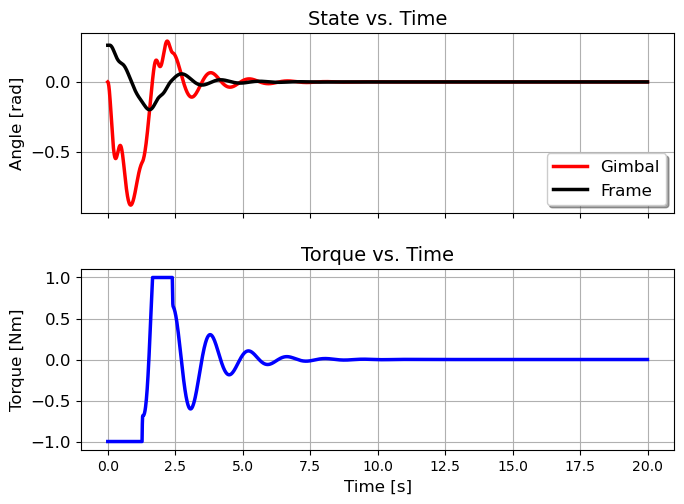

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

axes[0].plot(data['time'], data['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].plot(data['time'], data['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

axes[1].plot(data['time'], data['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

fig.tight_layout(pad=2.0)
plt.show()

## Simulation 2

In [21]:
# Creates a new instance of the cart simulator
sim2 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7037/static/


In [22]:
# initial frame angle increased to pi/10 radians from pi/12

data2 = sim2.run(controller,
               max_time = 20.0,
               initial_frame_angle = np.pi/10,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = 100.,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


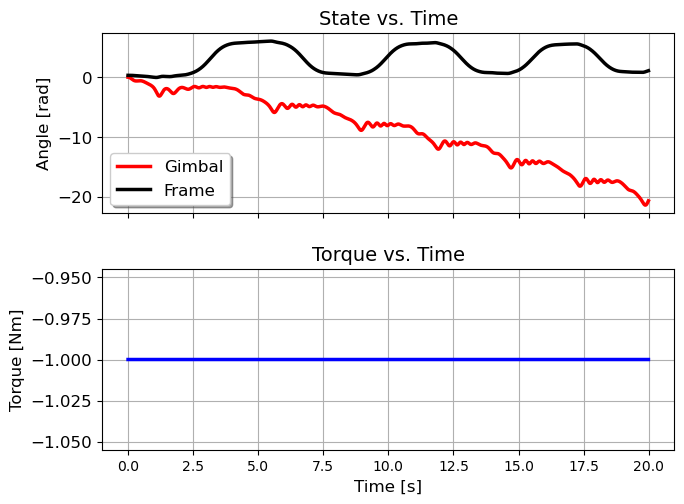

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

axes[0].plot(data2['time'], data2['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].plot(data2['time'], data2['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

axes[1].plot(data2['time'], data2['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

fig.tight_layout(pad=2.0)
plt.show()

## Simulation 3

In [24]:
# Creates a new instance of the cart simulator
sim3 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7038/static/


In [25]:
# initial gimbal velocity increased to 2.0 from 0.0

data3 = sim3.run(controller,
               max_time = 20.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 2.0,
               rotor_velocity = 100.,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


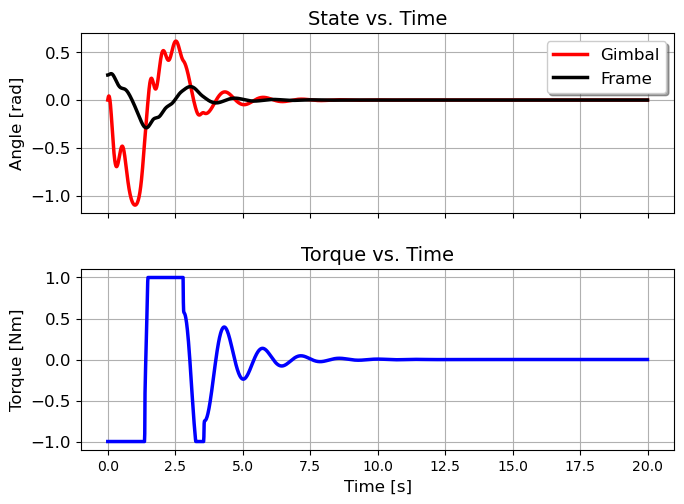

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

axes[0].plot(data3['time'], data3['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].plot(data3['time'], data3['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

axes[1].plot(data3['time'], data3['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

fig.tight_layout(pad=2.0)
plt.show()

## Simulation 4

In [27]:
# Creates a new instance of the cart simulator
sim4 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7039/static/


In [28]:
# initial frame velocity increased to 2.0 from 0.0

data4 = sim4.run(controller,
               max_time = 20.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 2.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = 100.,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


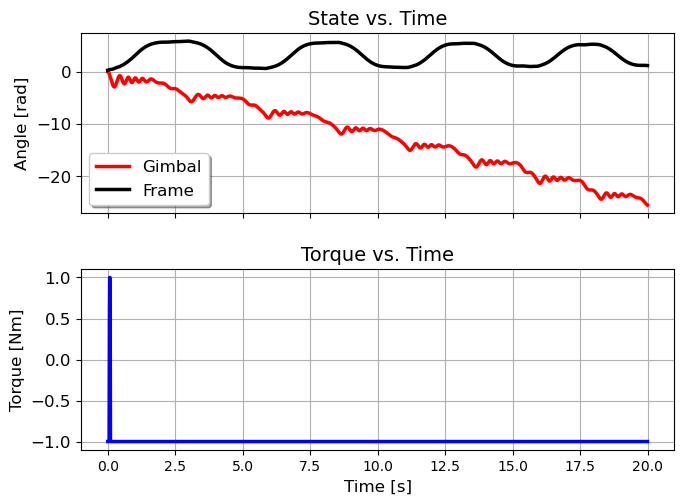

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

axes[0].plot(data4['time'], data4['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].plot(data4['time'], data4['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

axes[1].plot(data4['time'], data4['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

fig.tight_layout(pad=2.0)
plt.show()

## Simulation 5

In [30]:
# Creates a new instance of the cart simulator
sim5 = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7040/static/


In [31]:
# rotor velocity increased from 100 to 300

data5 = sim5.run(controller,
               max_time = 20.0,
               initial_frame_angle = np.pi/12,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 2.0,
               rotor_velocity = 300,
               frame_damping = 0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


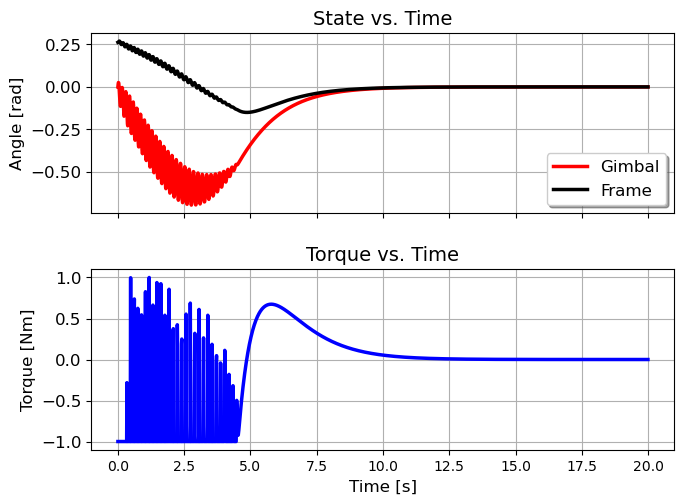

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

axes[0].plot(data5['time'], data5['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].plot(data5['time'], data5['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

axes[1].plot(data5['time'], data5['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

fig.tight_layout(pad=2.0)
plt.show()